# バス遅延予測モデルの構築と評価（バンクーバー）

## 概要
石長 篤人らの論文「運行情報と気象情報の畳み込みによるバス到着時刻予測手法の提案と評価」を参考に、  
バンクーバーのGTFSデータ特性に合わせて、畳み込みLSTM (Convolutional LSTM) を用いた**遅延時間予測モデル**を構築・評価します。

### 主要なアプローチ
- **気象情報の活用**: 天候、気温、降水量を組み込んだ遅延予測
- **遅延時間の直接予測**: arrival_delayを目標変数とした予測（停車時間データなしの制約に対応）
- **双方向LSTM**: 順方向と逆方向の伝搬による学習能力向上
- **route_id + direction_id対応**: 複数路線・上り下り別の独立学習

### バンクーバーデータの特性
- **制約**: 停車時間データが直接取得できない
- **対応**: 遅延時間（arrival_delay）を予測目標として活用
- **利点**: 実用的な「何分遅れるか」の情報提供

# バス到着時刻予測モデルの構築と評価

## 概要
石長 篤人らの論文「運行情報と気象情報の畳み込みによるバス到着時刻予測手法の提案と評価」に基づき、  
畳み込みLSTM (Convolutional LSTM) を用いて、気象情報と運行情報を統合したバス到着時刻予測モデルを構築・評価します。

### 主要なアプローチ
- **気象情報の活用**: 天候、気温、降水量を組み込んだ予測
- **走行時間と停車時間の個別予測**: それぞれに特化したモデル
- **双方向LSTM**: 順方向と逆方向の伝搬による学習能力向上

In [ ]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# カスタムモジュールのインポート
import sys
sys.path.append('/workspace/GTFS')

from src.timeseries_processing import SequenceCreator, DataSplitter, DataStandardizer
from src.model_training import DelayPredictionModel
from src.evaluation import ModelEvaluator, ModelVisualizer

pd.set_option('display.max_columns', None)

In [ ]:
delay_features = pd.read_csv('/workspace/GTFS/merged_dataset.csv')
feature_cols = ['weather', 'temp', 'precipitation', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
target_col = 'arrival_delay'

### 2.6-1 時系列データの作成

In [ ]:
# 時系列シーケンス作成（カスタムモジュール使用）
sequence_creator = SequenceCreator(input_timesteps=8, output_timesteps=3)

print("Creating route_id + direction_id-aware sequences for delay prediction...")
X_delay, y_delay, route_direction_info, used_features = sequence_creator.create_route_direction_aware_sequences(
    delay_features,
    target_col,
    feature_cols
)

print(f"使用された特徴量: {used_features}")
print(f"シーケンス形状: X={X_delay.shape}, y={y_delay.shape}")

Creating route_id + direction_id-aware sequences for delay prediction...
=== Sequence Creation by Route ID + Direction ID ===
Input time series length: 8 hours
Prediction time series length: 3 hours
route_id 6612, direction_id 0: 5433 records -> 5423 sequences generated
route_id 6612, direction_id 1: 6298 records -> 6288 sequences generated

Total sequences: 11711
X shape: (11711, 8, 7)
y shape: (11711, 3)


### 2.7 データ分割

In [8]:
# データ分割
data_splitter = DataSplitter()
X_delay_train, X_delay_test, y_delay_train, y_delay_test = data_splitter.train_test_split_temporal(
    X_delay, y_delay, train_ratio=0.9
)

print(f"\n=== Delay Prediction Data Split Results ===")
print(f"  Training data: X={X_delay_train.shape}, y={y_delay_train.shape}")
print(f"  Test data: X={X_delay_test.shape}, y={y_delay_test.shape}")

# データ標準化
standardizer = DataStandardizer()
X_delay_train_scaled = standardizer.fit_transform_features(X_delay_train)
X_delay_test_scaled = standardizer.transform_features(X_delay_test)
y_delay_train_scaled = standardizer.fit_transform_targets(y_delay_train)
y_delay_test_scaled = standardizer.transform_targets(y_delay_test)


=== Delay Prediction Data Split Results ===
  Training data: X=(3101, 10), y=(3101,)
  Test data: X=(345, 10), y=(345,)


In [ ]:
# ConvLSTM用reshape
actual_feature_count = X_delay_train_scaled.shape[2]
X_delay_train_reshaped = data_splitter.reshape_for_convlstm(
    X_delay_train_scaled, target_height=1, target_width=actual_feature_count
) 
X_delay_test_reshaped = data_splitter.reshape_for_convlstm(
    X_delay_test_scaled, target_height=1, target_width=actual_feature_count
)

print(f"\n=== ConvLSTM Reshape Results ===")
print(f"Training data: {X_delay_train_reshaped.shape} (samples, timesteps, height, width, channels)")
print(f"Test data: {X_delay_test_reshaped.shape}")

In [ ]:
# モデル構築（カスタムモジュール使用）
INPUT_TIMESTEPS = 8
OUTPUT_TIMESTEPS = 3

# 遅延予測用モデルの作成
model_trainer = DelayPredictionModel(
    input_timesteps=INPUT_TIMESTEPS,
    output_timesteps=OUTPUT_TIMESTEPS
)

# モデル構築
input_shape = (INPUT_TIMESTEPS, 1, actual_feature_count, 1)  # (timesteps, height, width, channels) 
delay_model = model_trainer.build_model(input_shape)

print(f"\n=== Model Configuration ===")
print(f"Input shape: {input_shape}")
print(f"Feature count: {actual_feature_count}")
print(f"Model ready for training")

2025-09-02 01:33:50.195115: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


=== 遅延予測用ConvLSTMモデル ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 1, 7, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 1, 1, 128)   │       233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 1, 1, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 1, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1, 1, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 1, 1, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 3, 1, 1, 64)    │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 1, 1, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 1, 1, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 3, 1, 1, 32)    │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 1, 1, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 1, 1, 1)     │            33 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,073 (1.19 MB)

 Trainable params: 310,497 (1.18 MB)

 Non-trainable params: 576 (2.25 KB)


=== モデル詳細情報 ===
入力形状: (None, 8, 1, 7, 1)
出力形状: (None, 3)
総パラメータ数: 311,073

=== 層構成 ===
層 0: input_layer
層 1: bidirectional
層 2: batch_normalization
層 3: dropout
層 4: bidirectional_1
層 5: batch_normalization_1
層 6: dropout_1
層 7: flatten
層 8: repeat_vector
層 9: reshape
層 10: bidirectional_2
層 11: batch_normalization_2
層 12: dropout_2
層 13: bidirectional_3
層 14: batch_normalization_3
層 15: time_distributed
層 16: reshape_1

=== ConvLSTM層の設定 ===

注意: 5次元特徴量（weather, temp, precipitation, travel_time_duration, arrival_delay_scaled）に対応
予測目標: 遅延時間（arrival_delay_scaled）


In [ ]:
# モデル訓練（カスタムモジュール使用）
print("=== Delay Prediction Model Training Started ===")

# 訓練実行
history = model_trainer.train_model(
    X_delay_train_reshaped, 
    y_delay_train_scaled,
    batch_size=32, 
    epochs=50, 
    validation_split=0.2,
    model_path='best_delay_model.h5'
)

if history is not None:
    print("Training completed successfully!")
else:
    print("Training failed. Please check the error messages above.")

=== 遅延予測モデル訓練開始 ===
訓練データ形状: (9801, 8, 1, 7, 1)
テストデータ形状: (1089, 8, 1, 7, 1)
目標変数データ型: float64

=== データ詳細確認 ===
訓練データタイプ: <class 'numpy.ndarray'>
目標データタイプ: <class 'numpy.ndarray'>
訓練データ実際の型: float64
目標データ実際の型: float64

データ品質チェック:
  X_train NaN数: 0
  y_train NaN数: 0
  X_train 無限大数: 0
  y_train 無限大数: 0

=== データタイプ変換 ===
変換後 X_train dtype: float32
変換後 y_train dtype: float32
変換後 X_train shape: (9801, 8, 1, 7, 1)
変換後 y_train shape: (9801, 3)

=== 入力特徴量詳細 ===
特徴量次元（width）: 7
5次元配列形状: (samples, timesteps, height, width, channels)
実際の形状: (9801, 8, 1, 7, 1)
特徴量内容:
  1. weather (天候コード)
  2. temperature (気温)
  3. precipitation (降水量)
  4. travel_time_duration (走行時間)
  5. arrival_delay_scaled (遅延時間)

=== 訓練データ統計 ===
遅延目標値 (y_delay_train):
  平均: -0.000
  標準偏差: 1.000
  最小値: -3.082
  最大値: 3.028

特徴量統計 (最後の時間ステップ):
  weather: 平均=4.212, std=3.797
  temperature: 平均=0.001, std=0.999
  precipitation: 平均=-0.001, std=1.000
  travel_time: 平均=0.000, std=1.000
  arrival_delay: 平均=3.774, std=1.952

=== 安全な訓練設定 =

245/245 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - delay_direction_accuracy: 0.6642 - delay_rmse: 0.9791 - loss: 0.9900 - mae: 0.7620 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7142 - val_delay_rmse: 0.7847 - val_loss: 0.6543 - val_mae: 0.6479 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - delay_direction_accuracy: 0.7088 - delay_rmse: 0.8483 - loss: 0.7278 - mae: 0.6679 - on_time_prediction_accuracy: 1.0000
Epoch 2: val_loss improved from 0.65426 to 0.59242, saving model to best_delay_model.h5

Epoch 2: val_loss improved from 0.65426 to 0.59242, saving model to best_delay_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - delay_direction_accuracy: 0.7108 - delay_rmse: 0.8336 - loss: 0.7022 - mae: 0.6561 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7347 - val_delay_rmse: 0.7463 - val_loss: 0.5924 - val_mae: 0.6109 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - delay_direction_accuracy: 0.7370 - delay_rmse: 0.8033 - loss: 0.6531 - mae: 0.6300 - on_time_prediction_accuracy: 1.0000
Epoch 3: val_loss improved from 0.59242 to 0.56760, saving model to best_delay_model.h5

Epoch 3: val_loss improved from 0.59242 to 0.56760, saving model to best_delay_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - delay_direction_accuracy: 0.7335 - delay_rmse: 0.7931 - loss: 0.6359 - mae: 0.6216 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7392 - val_delay_rmse: 0.7323 - val_loss: 0.5676 - val_mae: 0.5913 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 4/50
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - delay_direction_accuracy: 0.7425 - delay_rmse: 0.7899 - loss: 0.6313 - mae: 0.6205 - on_time_prediction_accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.56760
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - delay_direction_accuracy: 0.7387 - delay_rmse: 0.7847 - loss: 0.6228 - mae: 0.6157 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7408 - val_delay_rmse: 0.7314 - val_loss: 0.5715 - val_mae: 0.5916 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_loss did not improve from 0.56760
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/ste

245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - delay_direction_accuracy: 0.7429 - delay_rmse: 0.7785 - loss: 0.6123 - mae: 0.6085 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7445 - val_delay_rmse: 0.7281 - val_loss: 0.5627 - val_mae: 0.5845 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 6/50
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - delay_direction_accuracy: 0.7517 - delay_rmse: 0.7755 - loss: 0.6078 - mae: 0.6060 - on_time_prediction_accuracy: 1.0000
Epoch 6: val_loss improved from 0.56273 to 0.55921, saving model to best_delay_model.h5

Epoch 6: val_loss improved from 0.56273 to 0.55921, saving model to best_delay_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - delay_direction_accuracy: 0.7460 - delay_rmse: 0.7730 - loss: 0.6038 - mae: 0.6041 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7434 - val_delay_rmse: 0.7259 - val_loss: 0.5592 - val_mae: 0.5817 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - delay_direction_accuracy: 0.7476 - delay_rmse: 0.7701 - loss: 0.6006 - mae: 0.6031 - on_time_prediction_accuracy: 1.0000
Epoch 7: val_loss did not improve from 0.55921
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - delay_direction_accuracy: 0.7462 - delay_rmse: 0.7662 - loss: 0.5937 - mae: 0.5994 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7461 - val_delay_rmse: 0.7235 - val_loss: 0.5653 - val_mae: 0.5806 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010

Epoch 7: val_loss did not improve from 0.55921
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - delay_d

245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - delay_direction_accuracy: 0.7510 - delay_rmse: 0.7568 - loss: 0.5796 - mae: 0.5900 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7493 - val_delay_rmse: 0.7218 - val_loss: 0.5591 - val_mae: 0.5779 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 13/50
Epoch 13/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - delay_direction_accuracy: 0.7567 - delay_rmse: 0.7583 - loss: 0.5822 - mae: 0.5904 - on_time_prediction_accuracy: 1.0000
Epoch 13: val_loss did not improve from 0.55911
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - delay_direction_accuracy: 0.7527 - delay_rmse: 0.7568 - loss: 0.5792 - mae: 0.5904 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7476 - val_delay_rmse: 0.7245 - val_loss: 0.5611 - val_mae: 0.5832 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 14/50

Epoch 13: val_loss did not improve from 0.55911
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 74m

245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - delay_direction_accuracy: 0.7503 - delay_rmse: 0.7580 - loss: 0.5811 - mae: 0.5905 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7483 - val_delay_rmse: 0.7248 - val_loss: 0.5571 - val_mae: 0.5872 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - delay_direction_accuracy: 0.7564 - delay_rmse: 0.7599 - loss: 0.5846 - mae: 0.5922 - on_time_prediction_accuracy: 1.0000
Epoch 15: val_loss did not improve from 0.55708
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - delay_direction_accuracy: 0.7521 - delay_rmse: 0.7547 - loss: 0.5761 - mae: 0.5879 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7471 - val_delay_rmse: 0.7235 - val_loss: 0.5594 - val_mae: 0.5834 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_loss did not improve from 0.55708
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76m

245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - delay_direction_accuracy: 0.7526 - delay_rmse: 0.7539 - loss: 0.5751 - mae: 0.5875 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7460 - val_delay_rmse: 0.7194 - val_loss: 0.5520 - val_mae: 0.5763 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 18/50
Epoch 18/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - delay_direction_accuracy: 0.7577 - delay_rmse: 0.7538 - loss: 0.5754 - mae: 0.5867 - on_time_prediction_accuracy: 1.0000
Epoch 18: val_loss improved from 0.55196 to 0.55169, saving model to best_delay_model.h5

Epoch 18: val_loss improved from 0.55196 to 0.55169, saving model to best_delay_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - delay_direction_accuracy: 0.7539 - delay_rmse: 0.7520 - loss: 0.5720 - mae: 0.5846 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7478 - val_delay_rmse: 0.7207 - val_loss: 0.5517 - val_mae: 0.5768 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 19/50
Epoch 19/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - delay_direction_accuracy: 0.7565 - delay_rmse: 0.7554 - loss: 0.5780 - mae: 0.5898 - on_time_prediction_accuracy: 1.0000
Epoch 19: val_loss improved from 0.55169 to 0.55129, saving model to best_delay_model.h5

Epoch 19: val_loss improved from 0.55169 to 0.55129, saving model to best_delay_model.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - delay_direction_accuracy: 0.7534 - delay_rmse: 0.7520 - loss: 0.5721 - mae: 0.5859 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7480 - val_delay_rmse: 0.7174 - val_loss: 0.5513 - val_mae: 0.5734 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 20/50
Epoch 20/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - delay_direction_accuracy: 0.7610 - delay_rmse: 0.7518 - loss: 0.5729 - mae: 0.5850 - on_time_prediction_accuracy: 1.0000
Epoch 20: val_loss did not improve from 0.55129
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - delay_direction_accuracy: 0.7560 - delay_rmse: 0.7503 - loss: 0.5695 - mae: 0.5833 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7471 - val_delay_rmse: 0.7217 - val_loss: 0.5536 - val_mae: 0.5762 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 21/50

Epoch 20: val_loss did not improve from 0.55129
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76m

245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - delay_direction_accuracy: 0.7562 - delay_rmse: 0.7493 - loss: 0.5678 - mae: 0.5836 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7520 - val_delay_rmse: 0.7155 - val_loss: 0.5428 - val_mae: 0.5687 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 26/50
Epoch 26/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - delay_direction_accuracy: 0.7601 - delay_rmse: 0.7513 - loss: 0.5722 - mae: 0.5821 - on_time_prediction_accuracy: 1.0000
Epoch 26: val_loss did not improve from 0.54284
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - delay_direction_accuracy: 0.7560 - delay_rmse: 0.7477 - loss: 0.5657 - mae: 0.5802 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7515 - val_delay_rmse: 0.7158 - val_loss: 0.5474 - val_mae: 0.5692 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 27/50

Epoch 26: val_loss did not improve from 0.54284
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76m

245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - delay_direction_accuracy: 0.7561 - delay_rmse: 0.7465 - loss: 0.5638 - mae: 0.5807 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7478 - val_delay_rmse: 0.7123 - val_loss: 0.5423 - val_mae: 0.5691 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 29/50
Epoch 29/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - delay_direction_accuracy: 0.7597 - delay_rmse: 0.7478 - loss: 0.5659 - mae: 0.5811 - on_time_prediction_accuracy: 1.0000
Epoch 29: val_loss did not improve from 0.54227
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - delay_direction_accuracy: 0.7555 - delay_rmse: 0.7453 - loss: 0.5618 - mae: 0.5786 - on_time_prediction_accuracy: 1.0000 - val_delay_direction_accuracy: 0.7512 - val_delay_rmse: 0.7174 - val_loss: 0.5482 - val_mae: 0.5713 - val_on_time_prediction_accuracy: 1.0000 - learning_rate: 0.0010

Epoch 29: val_loss did not improve from 0.54227
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - del

=== 遅延予測モデル評価 ===
テストデータでの予測実行中...
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step
予測結果形状: (1089, 3)
実際の値形状: (1089, 3)

=== 全体評価結果 ===
平均絶対誤差 (MAE): 108.683 秒
二乗平均平方根誤差 (RMSE): 136.543 秒
決定係数 (R²): -0.006
方向予測精度: 0.651
定時予測精度: 0.322

=== 範囲別予測精度 ===
30秒以内: 0.171
1分以内: 0.325
2分以内: 0.616
5分以内: 0.966
予測結果形状: (1089, 3)
実際の値形状: (1089, 3)

=== 全体評価結果 ===
平均絶対誤差 (MAE): 108.683 秒
二乗平均平方根誤差 (RMSE): 136.543 秒
決定係数 (R²): -0.006
方向予測精度: 0.651
定時予測精度: 0.322

=== 範囲別予測精度 ===
30秒以内: 0.171
1分以内: 0.325
2分以内: 0.616
5分以内: 0.966


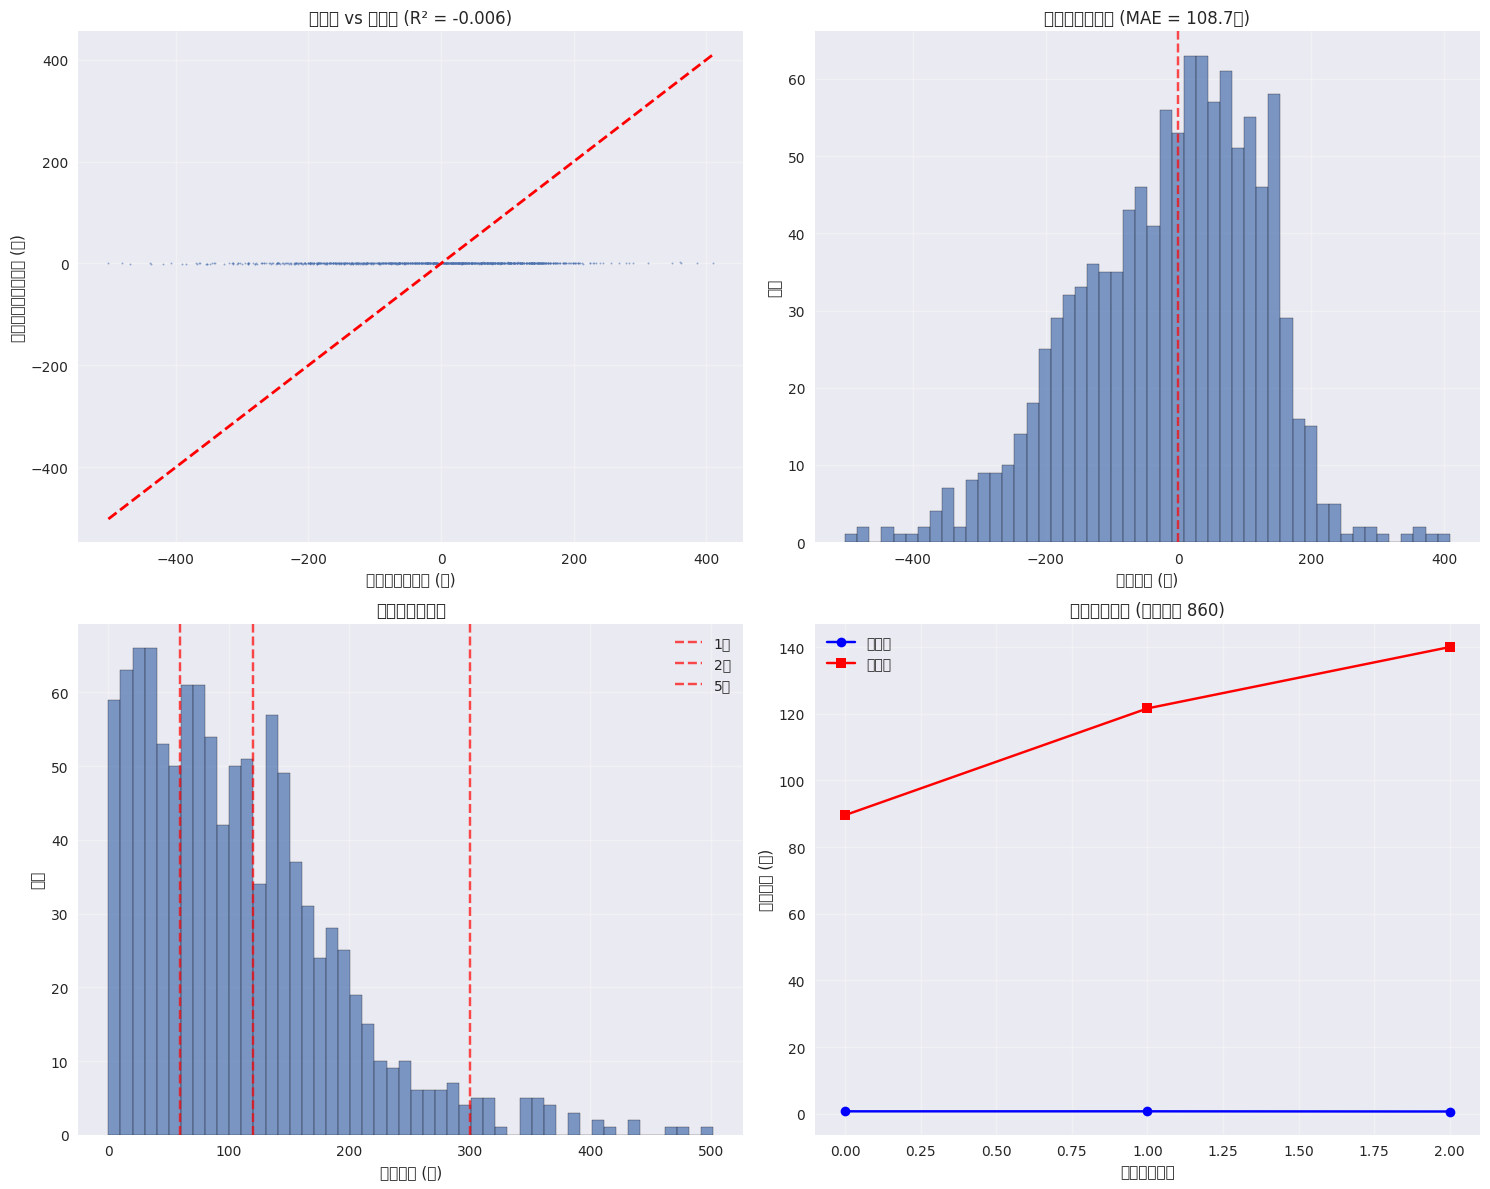


=== 予測精度サマリー ===
• 平均絶対誤差: 1.81 分
• RMSE: 2.28 分
• 方向予測精度: 65.1%
• 1分以内予測精度: 32.5%
• 2分以内予測精度: 61.6%


In [ ]:
# モデル評価・可視化（カスタムモジュール使用）
print("=== Delay Prediction Model Evaluation ===")

# 予測実行
predictions = model_trainer.predict(X_delay_test_reshaped, batch_size=32)

print(f"Prediction result shape: {predictions.shape}")
print(f"Actual value shape: {y_delay_test.shape}")

# 最新の予測値のみを使用（系列の最後）
delay_pred_final = predictions[:, -1] if predictions.ndim > 1 else predictions
y_test_final = y_delay_test[:, -1] if y_delay_test.ndim > 1 else y_delay_test

# 評価
evaluator = ModelEvaluator()
overall_metrics = evaluator.calculate_delay_metrics(y_test_final, delay_pred_final)
delay_level_analysis = evaluator.analyze_by_delay_level(y_test_final, delay_pred_final)

# 評価結果表示
evaluator.print_evaluation_summary(overall_metrics, delay_level_analysis)

# 可視化
visualizer = ModelVisualizer()

# 予測分析の可視化
visualizer.plot_prediction_analysis(y_test_final, delay_pred_final, overall_metrics)

In [ ]:
# 詳細分析・可視化（カスタムモジュール使用）
print("=== Route-wise and Time-period-wise Delay Prediction Analysis ===")

# 遅延レベル別分析の可視化
visualizer.plot_delay_level_analysis(y_test_final, delay_pred_final, delay_level_analysis)

# 訓練履歴の可視化
if history is not None:
    visualizer.plot_training_history(history)
else:
    print("訓練履歴が利用できません")

# モデル保存
model_trainer.save_model('delay_prediction_model_final.h5')

print(f"\n=== Final Results Summary ===")
print(f"• Mean Absolute Error: {overall_metrics['mae']/60:.2f} minutes")
print(f"• RMSE: {overall_metrics['rmse']/60:.2f} minutes")  
print(f"• R² Score: {overall_metrics['r2']:.3f}")
print(f"• Direction prediction accuracy: {overall_metrics['direction_accuracy']*100:.1f}%")
print(f"• Within 1 minute accuracy: {overall_metrics['range_accuracies']['Within 1min']*100:.1f}%")
print(f"• Within 2 minutes accuracy: {overall_metrics['range_accuracies']['Within 2min']*100:.1f}%")

print("\n=== モジュール化完了 ===")
print("全ての処理がカスタムモジュールを使用して実行されました。")